In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_percentage_error
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data, calculate_alive_path
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions, \
    plot_history_alive, plot_cumulative_transactions, plot_calibration_purchases_vs_holdout_purchases, plot_transaction_rate_heterogeneity, plot_dropout_rate_heterogeneity


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def preprocessing(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    for col in ['category_3']:
        df[col] = df[col].map({'A':1, 'B':2,'C':3})
    return df

def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (pd.Timestamp('2018-02-01') - df['first_active_month']).dt.days
    return df

In [4]:
# データの読み込み
path_new = '../../../../data/raw/new_merchant_transactions.csv'
path_hist = '../../../../data/raw/historical_transactions.csv'
path_train = '../../../../data/raw/train.csv'
path_test = '../../../../data/raw/test.csv'

new = pd.read_csv(path_new, parse_dates=['purchase_date'])
hist = pd.read_csv(path_hist ,parse_dates=['purchase_date'])

new= preprocessing(new)
hist = preprocessing(hist)

#new = reduce_mem_usage(new)
#hist = reduce_mem_usage(hist)

#train = pd.read_csv(path_train, parse_dates=['first_active_month'])
#test = pd.read_csv(path_test, parse_dates=['first_active_month'])

#target = train['target']
#del train['target']

In [5]:
for df in [hist, new]:
    df['purchase_amount'] = np.round(df['purchase_amount'] / 0.00150265118 + 497.06)

In [10]:
df

,card_id,purchase_amount,purchase_date
0,C_ID_4e6213e9bc,29.0,2017-06-25
1,C_ID_4e6213e9bc,9.0,2017-07-15
2,C_ID_4e6213e9bc,18.0,2017-08-09
3,C_ID_4e6213e9bc,8.0,2017-09-02
4,C_ID_4e6213e9bc,16.0,2017-03-10
...,...,...,...
26595447,C_ID_2863d2fa95,76.0,2017-01-20
26595448,C_ID_2863d2fa95,76.0,2017-02-20
26595449,C_ID_5c240d6e3c,59.0,2017-12-26
26595450,C_ID_5c240d6e3c,1010.0,2017-11-24


In [7]:
df = hist.query('authorized_flag == 1').reset_index(drop=True)
df = df[['card_id', 'purchase_amount', 'purchase_date']]
df

,card_id,purchase_amount,purchase_date
0,C_ID_4e6213e9bc,29.0,2017-06-25 15:33:07
1,C_ID_4e6213e9bc,9.0,2017-07-15 12:10:45
2,C_ID_4e6213e9bc,18.0,2017-08-09 22:04:29
3,C_ID_4e6213e9bc,8.0,2017-09-02 10:06:26
4,C_ID_4e6213e9bc,16.0,2017-03-10 01:14:19
...,...,...,...
26595447,C_ID_2863d2fa95,76.0,2017-01-20 08:52:04
26595448,C_ID_2863d2fa95,76.0,2017-02-20 04:40:50
26595449,C_ID_5c240d6e3c,59.0,2017-12-26 18:37:51
26595450,C_ID_5c240d6e3c,1010.0,2017-11-24 14:18:15


In [9]:
df["purchase_date"] = pd.to_datetime(df["purchase_date"]).dt.date #normalize()

In [13]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = df, 
    customer_id_col = "card_id", 
    datetime_col = "purchase_date", 
    monetary_value_col = "purchase_amount", 
    #observation_period_end = max_date, 
    freq = "D")
pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
card_id,,,,
C_ID_00007093c1,72,378,379,200
C_ID_0001238066,67,152,153,188
C_ID_0001506ef0,43,399,410,225
C_ID_0001793786,80,283,403,951
C_ID_000183fdda,73,175,178,314
...,...,...,...,...
C_ID_ffff1d9928,5,74,125,113
C_ID_ffff579d3a,67,199,204,42
C_ID_ffff756266,8,261,400,307


C:\Users\kakeru.oshikiri.bt\AppData\Local\Temp\ipykernel_21588\853126590.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_rft["frequency"])
C:\Users\kakeru.oshikiri.bt\AppData\Local\Temp\ipykernel_21588\853126590.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_rft["recenc

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

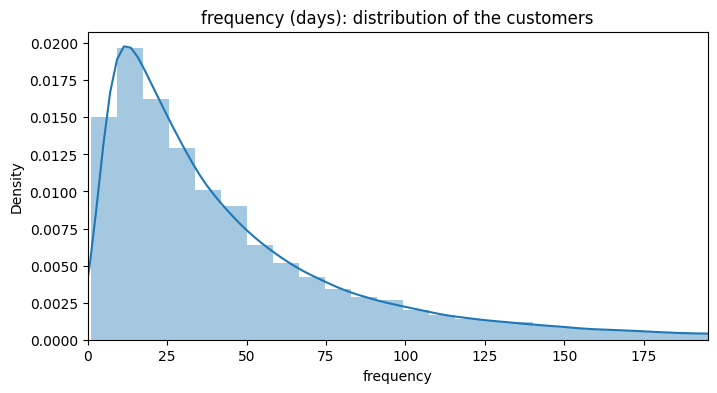

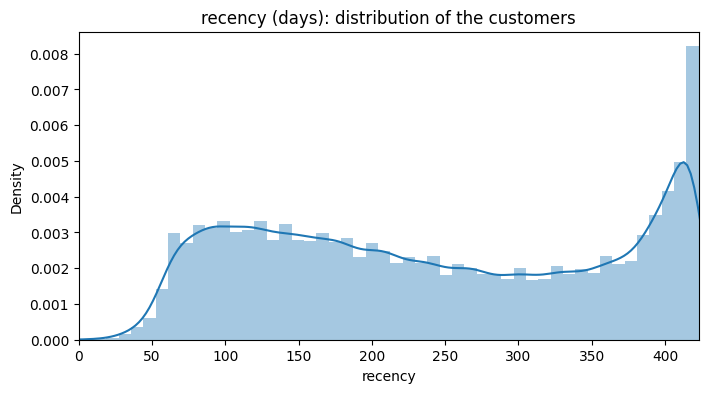

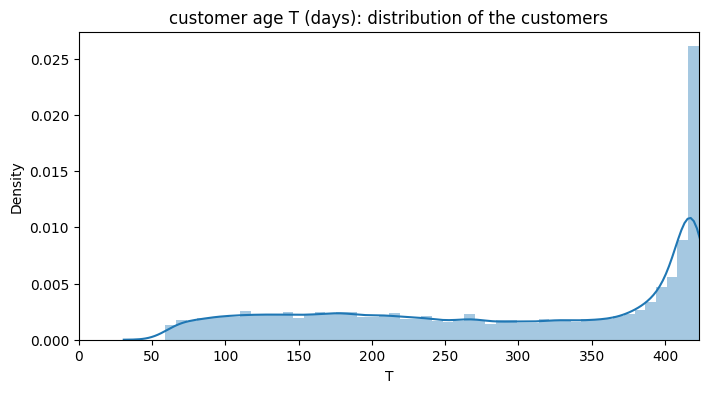

In [14]:
# axis length
max_freq = df_rft["frequency"].quantile(0.98)
max_rec = df_rft["recency"].max()
max_T = df_rft["T"].max()
# frequency
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_rft["frequency"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");
# recency
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_rft["recency"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")
# T
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_rft["T"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

In [15]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -171.532260
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31


,coef,se(coef),lower 95% bound,upper 95% bound
r,1.664,0.004,1.656,1.672
alpha,8.362,0.023,8.316,8.408
a,0.709,0.005,0.699,0.719
b,83.033,0.702,81.656,84.410


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 1200x1200 with 0 Axes>

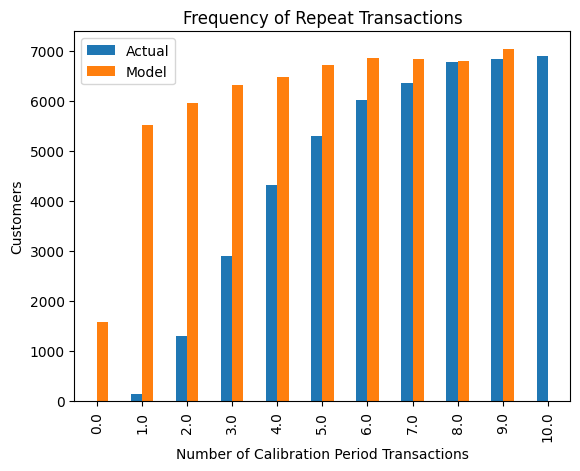

In [17]:
# 検証
# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf, 
            max_frequency = 10)